# Project Description and Goals

Insert brief description

### Objectives for this project include:
- Identifying ____.
- Documenting process and analysis throughout the data science pipeline.
- Demonstrating the information that was discovered.
- Deliverables:
    - [README.md](insert link) file containing overall project information, how to reproduce work, and notes from project planning.
    - Jupyter Notebook Report detailing the pipeline process.
    - Python module that automates the data [wrangling](insert link).

### Pipeline Process:
1. Acquire
2. Prepare
3. Explore
4. Model/Evaluate
5. Deliver

### Initial Questions
- Does the data increase, decrease, or stay the same over time?
- What is the distribution of yearly average temperature and yearly average uncertainty?
- What is the distribution of monthly average temperature and monthly average uncertainty?

***
### Project Imports

In [1]:
import numpy as np
import pandas as pd

import wrangle

#visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#for presentation purposes
import warnings
warnings.filterwarnings("ignore")

#working with dates
from datetime import timedelta, datetime

#evaluate performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

#time series analysis
import statsmodels.api as sm

#holt's linear trend model
from statsmodels.tsa.api import Holt

***
# Data Acquisition

In [2]:
#get the dataframe using wrangle.py script
df = wrangle.get_temps_data()
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [3]:
#rows and columns
df.shape

(645675, 5)

In [4]:
#list of column names and data types with more information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [5]:
#check nulls
df.isnull().sum()

dt                                   0
AverageTemperature               25648
AverageTemperatureUncertainty    25648
State                                0
Country                              0
dtype: int64

In [6]:
#check nulls in Texas
df[df.State.str.contains("Texas")].isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
State                            0
Country                          0
dtype: int64

In [7]:
#summary statistics for numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,620027.0,8.993111,13.772150,-45.389,-0.693,11.199,19.899,36.339
AverageTemperatureUncertainty,620027.0,1.287647,1.360392,0.036,0.316,0.656,1.850,12.646


array([[<AxesSubplot:title={'center':'AverageTemperature'}>,
        <AxesSubplot:title={'center':'AverageTemperatureUncertainty'}>]],
      dtype=object)

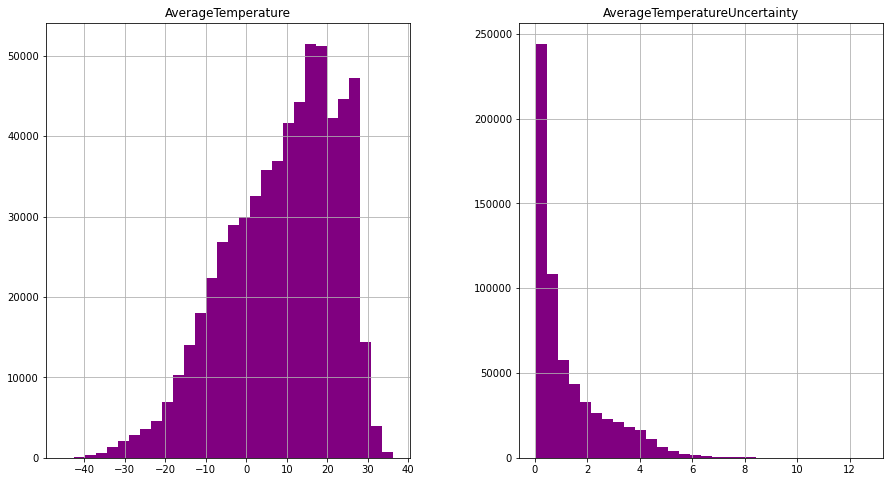

In [8]:
#initial plots
df.hist(bins=30,figsize=(15,8),color='purple')

### Findings
- dataset has lots of rows and needs to be cut down to soley Texas temperatures for this project.
- column names look messy and need better names for readability.
- date column (`dt`) is an object and needs to be converted to datetime dtype.
- `dt` should be set as index.
- need to drop `Country` and `State` columns since I will just be working with Texas data.
- nulls exist in the full data set, but not for temperatures in Texas, so no values need to be filled in.

***
# Data Preparation

In [9]:
#grab cleaned dataframe using the clean_temps function in wrangle.py
df = wrangle.clean_temps(df)
df.head()

,avg_temp,avg_uncertainty
date,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873
1820-03-01,12.657,2.423
1820-04-01,19.215,2.501
1820-05-01,22.577,2.495


In [10]:
#double check columns, nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2325 entries, 1820-01-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temp         2325 non-null   float64
 1   avg_uncertainty  2325 non-null   float64
dtypes: float64(2)
memory usage: 54.5 KB


In [11]:
#split the data using the split function in wrangle.py
train, validate, test = wrangle.split(df)

print('overall shape of dataframe:', df.shape)
print('train:', train.shape)
print('validate:', validate.shape)
print('test:', test.shape)

overall shape of dataframe: (2325, 2)
train: (1162, 2)
validate: (697, 2)
test: (466, 2)


#### Data is:
- cleaned/prepped
- split into train, validate, test for exploration.
- ready to be explored on training (in-sample) data.

***
# Data Exploration
Answer questions posed in planning/brainstorming

In [12]:
#add month and year column
train['month'] = train.index.month
train['year'] = train.index.year

train.head()

,avg_temp,avg_uncertainty,month,year
date,,,,
1820-01-01,4.489,3.369,1,1820
1820-02-01,9.081,2.873,2,1820
1820-03-01,12.657,2.423,3,1820
1820-04-01,19.215,2.501,4,1820
1820-05-01,22.577,2.495,5,1820


In [13]:
#set target y variables
y = train.avg_temp
y_unc = train.avg_uncertainty

y.head(), y_unc.head()

(date
 1820-01-01     4.489
 1820-02-01     9.081
 1820-03-01    12.657
 1820-04-01    19.215
 1820-05-01    22.577
 Name: avg_temp, dtype: float64,
 date
 1820-01-01    3.369
 1820-02-01    2.873
 1820-03-01    2.423
 1820-04-01    2.501
 1820-05-01    2.495
 Name: avg_uncertainty, dtype: float64)

#### Does the data increase, decrease, or stay the same over time?

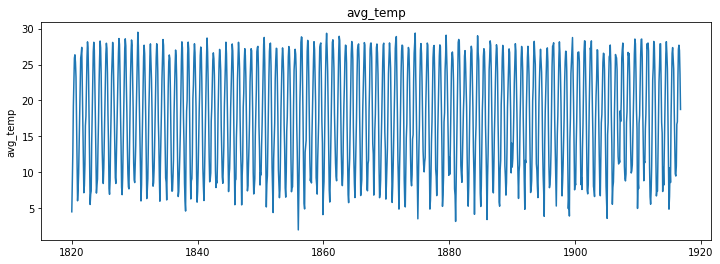

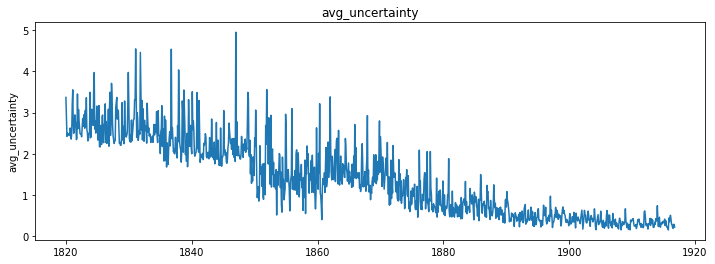

In [14]:
#loop to visualize avg temp/avg temp uncertainty over time
for col in train.columns:
    if col != 'month' and col != 'year':
        plt.figure(figsize=(12,4))
        plt.plot(train[col])
        plt.ylabel(col)
        plt.title(col)
        plt.show()

Text(0.5, 1.0, 'Aggregated Average Temperatures Over 6 Years')

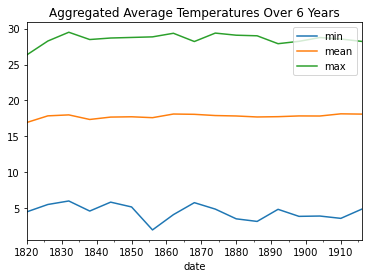

In [15]:
#visualize average_temp min, mean, max over 6 years
y.resample('6Y').agg(['min', 'mean', 'max']).plot()
plt.title("Aggregated Average Temperatures Over 6 Years")

Text(0.5, 1.0, 'Aggregated Average Uncertainty Over 6 Years')

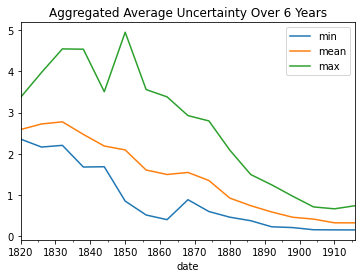

In [16]:
#visualize average_uncertainty min, mean, max over 6 years
y_unc.resample('6Y').agg(['min', 'mean', 'max']).plot()
plt.title("Aggregated Average Uncertainty Over 6 Years")

#### What is the distribution of yearly average temperature and yearly average uncertainty?

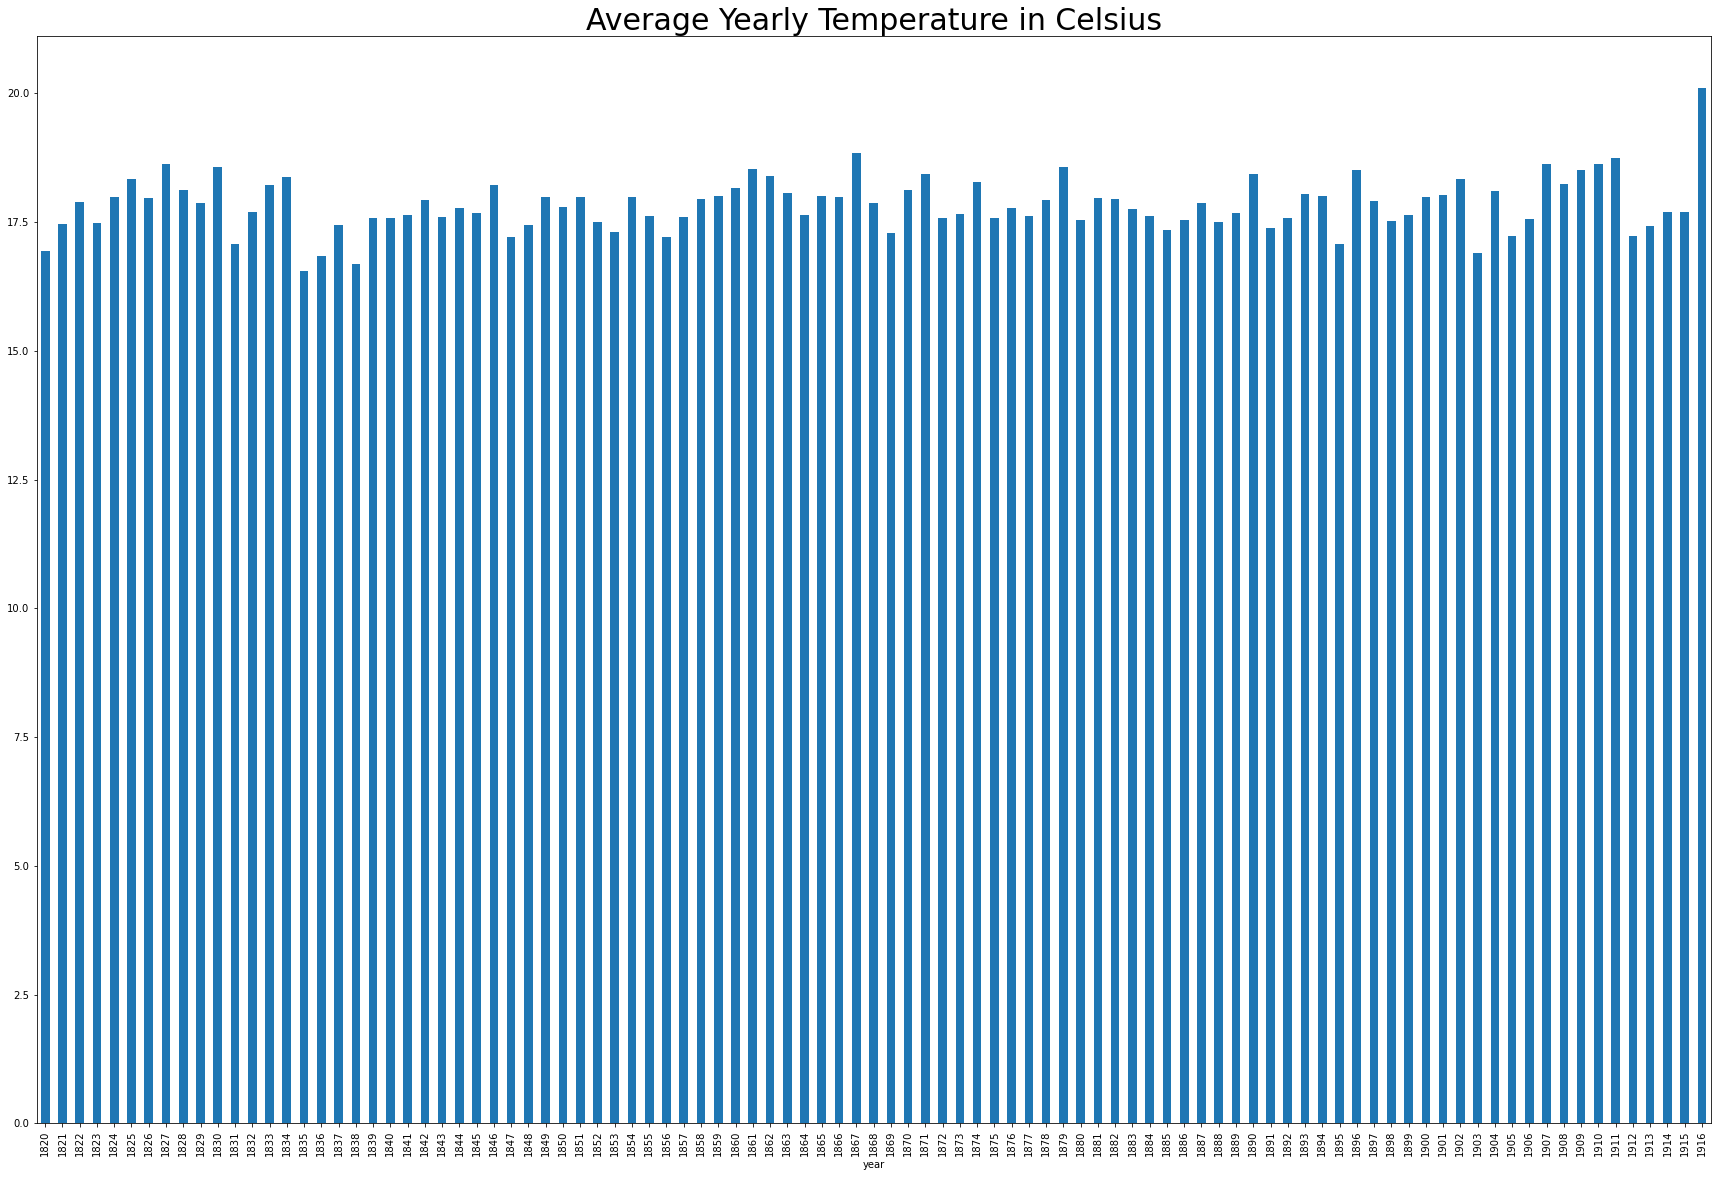

In [17]:
#yearly average temperature
train.groupby('year').avg_temp.mean().plot.bar(figsize=(30,20))
plt.title('Average Yearly Temperature in Celsius', fontsize=30)
plt.show()

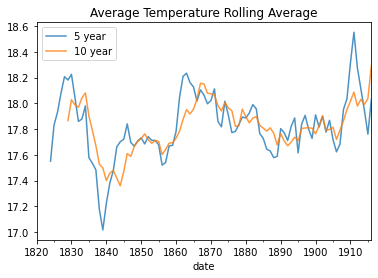

In [18]:
#reducing noise by resampling avg_temp data and rolling averages
y.resample('Y').mean().rolling(5).mean().plot(alpha=.8, label='5 year')
y.resample('Y').mean().rolling(10).mean().plot(alpha=.8, label='10 year')
plt.legend()
plt.title('Average Temperature Rolling Average')
plt.show()

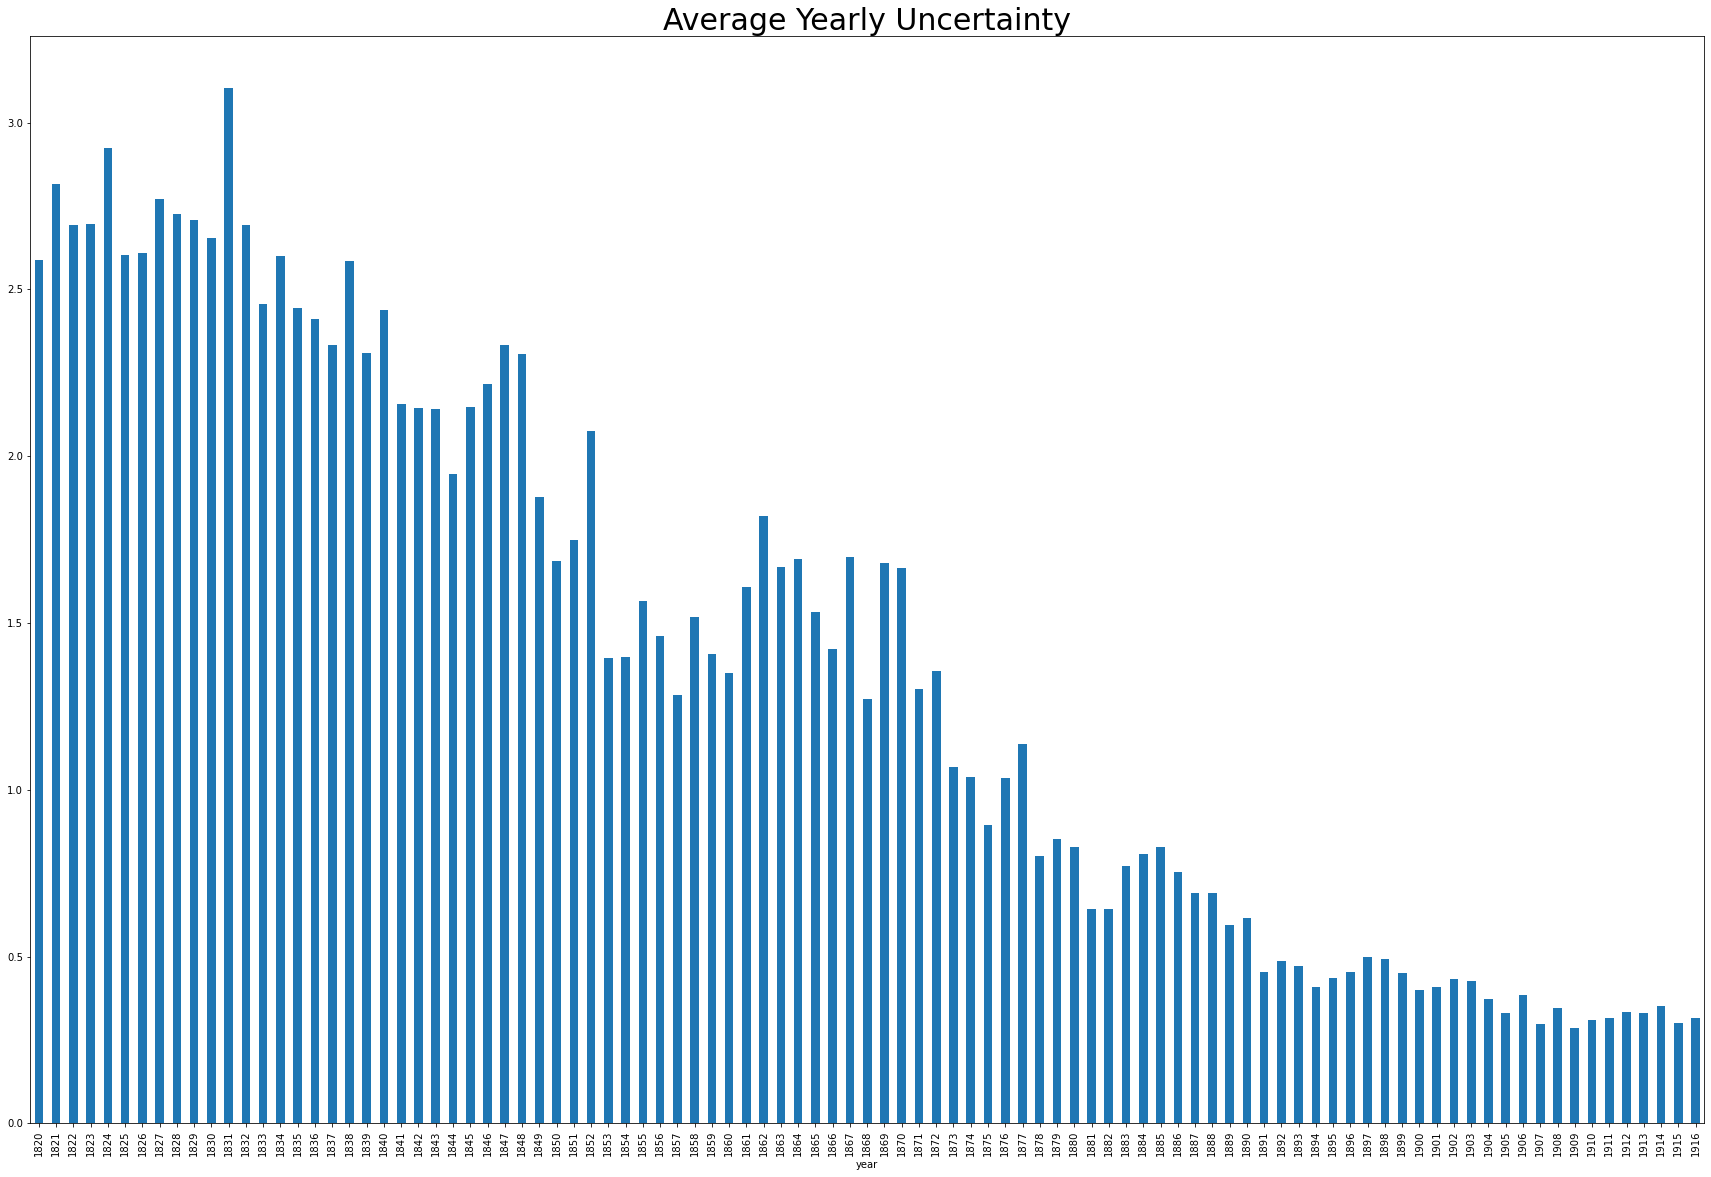

In [19]:
#yearly average uncertainty
train.groupby('year').avg_uncertainty.mean().plot.bar(figsize=(30,20))
plt.title('Average Yearly Uncertainty', fontsize=30)
plt.show()

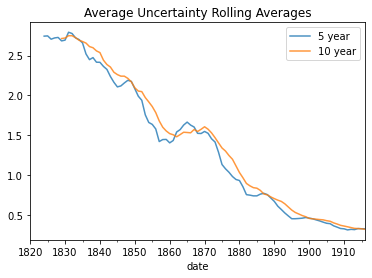

In [20]:
#reducing noise by resampling avg_uncertainty and rolling averages
y_unc.resample('Y').mean().rolling(5).mean().plot(alpha=.8, label='5 year')
y_unc.resample('Y').mean().rolling(10).mean().plot(alpha=.8, label='10 year')
plt.legend()
plt.title('Average Uncertainty Rolling Averages')
plt.show()

#### What is the distribution of monthly average temperature and monthly average uncertainty?

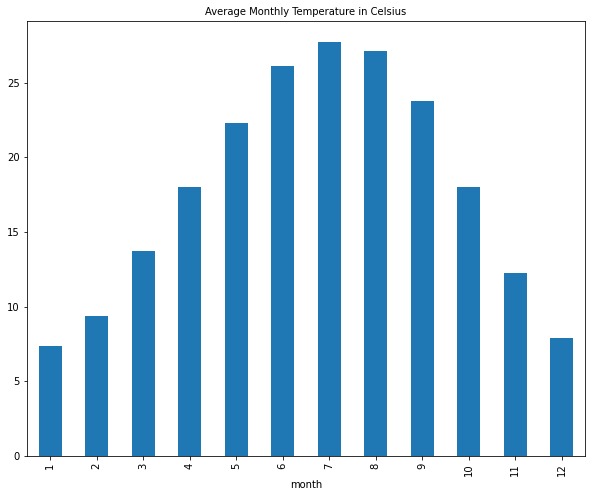

In [21]:
#monthly average temperature
train.groupby('month').avg_temp.mean().plot.bar(figsize=(10,8))
plt.title('Average Monthly Temperature in Celsius', fontsize=10)
plt.show()

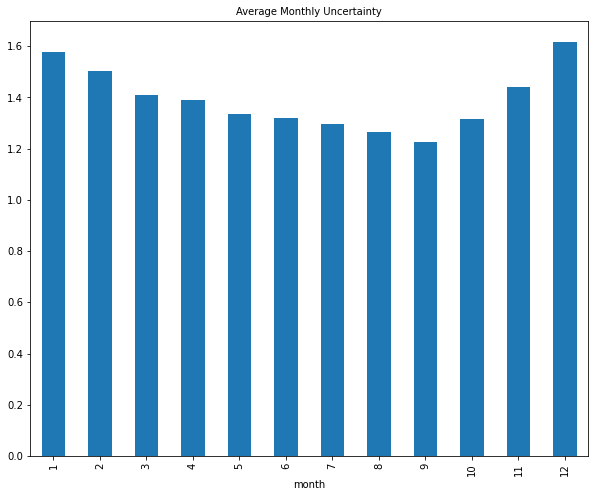

In [22]:
#monthly average uncertainty
train.groupby('month').avg_uncertainty.mean().plot.bar(figsize=(10,8))
plt.title('Average Monthly Uncertainty', fontsize=10)
plt.show()

### Takeaways
- Over time, yearly average temperature does not have much change, with exception of a few cold years, around 1858, 1877, and 1881 to name a few.
- Average uncertainty appears to be decreasing over time.




- Minimum, mean, and maximum average temperatures appears to stay roughly the same over 6 years, with a bit of spikes in minimum average temperatures, particularly between 1850 and 1870.
- Aggregated average uncertainty shows decreased over 6 years, possibly because of technological advances in measuring temperatures. 
- There is a spike in maximum average uncertainty around the year of 1850, not sure why. 



- There is not much variance in the distribution for yearly average temperature and yearly average uncertainty appears right-skewed.
- Rolling averages over 5 years shows cold average temperatures around 1839 and highest average temperatures around 1910.
- As expected, average uncertainty with rolling average appears to also be decreasing. 



- The distribution for monthly average temperature is normally distributed with higher average temperatures in the summer months and colder temperatures in winter months. 
- Average monthly uncertainty distribution shows higher average uncertainty within the colder months.
- There is a decrease in average uncertainty from January to September and then it begins to increase from October to December.

***
# Data Modeling / Evaluation

In [23]:
#dropping month and year columns for modeling/evaluation purposes
train = train.drop(columns=['month', 'year'])

train.head()

,avg_temp,avg_uncertainty
date,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873
1820-03-01,12.657,2.423
1820-04-01,19.215,2.501
1820-05-01,22.577,2.495


In [24]:
#apply predictions to observations
def make_predictions():
    yhat_df = pd.DataFrame({'avg_temp': [avg_temp],
                           'avg_uncertainty': [avg_uncertainty]}, 
                           index = validate.index)
    return yhat_df

#compute mean squared error and root mean squared error to evaluate
def evaluate(target_var):
    '''
    This function will take the actual values of the target variable from validate,
    and the predicted values stored in yhat_df,
    compute the rmse, rounding to 0 decimal places,
    and it will return the rmse.

    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


#use evaluate function and plot train, validate, and test values with the predicted values to compare performance
def plot_and_eval(target_var):
    '''
    This function takes in the target variable name (string),
    and returns a plot of the values of train for that variable, validate, and the predicted values from y_hat_df.
    It will also label the rmse.
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
    
    
#empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

#function to store the rmse to compare models
def append_eval_df(model_type, target_var):
    '''
    This function takes in the type of model run and name of target variable as arguments.
    It returns the eval_df with the rmse appended to it for that model and target variable
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Last Observed Value
Predict all future values to be the last observed value.

In [25]:
#take the last value of avg temp and assign to variable
avg_temp = round(train['avg_temp'][-1:][0], 2)
avg_temp

18.74

In [26]:
#take the last value of avg_uncertainty and assign to variable
avg_uncertainty = round(train['avg_uncertainty'][-1:][0], 2)
avg_uncertainty

0.22

In [27]:
#yhat df
yhat_df = make_predictions()
yhat_df.head()

,avg_temp,avg_uncertainty
date,,
1916-11-01,18.74,0.22
1916-12-01,18.74,0.22
1917-01-01,18.74,0.22
1917-02-01,18.74,0.22
1917-03-01,18.74,0.22


In [28]:
#double check values are the same
yhat_df.describe()

,avg_temp,avg_uncertainty
count,6.970000e+02,6.970000e+02
mean,1.874000e+01,2.200000e-01
std,1.813185e-13,9.721428e-16
min,1.874000e+01,2.200000e-01
25%,1.874000e+01,2.200000e-01
50%,1.874000e+01,2.200000e-01
75%,1.874000e+01,2.200000e-01
max,1.874000e+01,2.200000e-01


avg_temp -- RMSE: 7


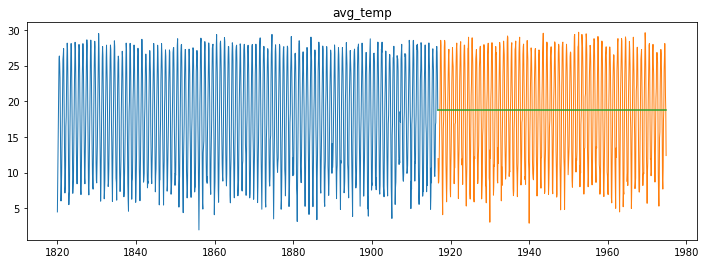

avg_uncertainty -- RMSE: 0


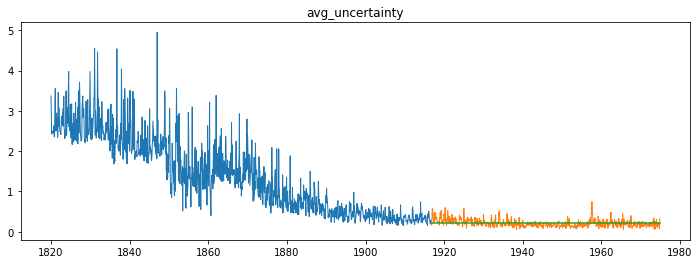

In [29]:
#plot actual vs predicted
for col in train.columns:
    plot_and_eval(col)

In [30]:
#evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,last_observed_value,avg_uncertainty,0.0


### Simple Average
Take the simple average of historical values and use that value to predict future values.

In [31]:
#avg_temp: establishing value of prediction 
avg_temp = round(train['avg_temp'].mean(), 2)
avg_temp

17.83

In [32]:
#avg_uncertainty: establishing value of prediction
avg_uncertainty = round(train['avg_uncertainty'].mean(), 2)
avg_uncertainty

1.39

In [33]:
yhat_df = make_predictions()
yhat_df.head()

,avg_temp,avg_uncertainty
date,,
1916-11-01,17.83,1.39
1916-12-01,17.83,1.39
1917-01-01,17.83,1.39
1917-02-01,17.83,1.39
1917-03-01,17.83,1.39


In [34]:
yhat_df.describe()

,avg_temp,avg_uncertainty
count,6.970000e+02,6.970000e+02
mean,1.783000e+01,1.390000e+00
std,6.399477e-14,1.155461e-14
min,1.783000e+01,1.390000e+00
25%,1.783000e+01,1.390000e+00
50%,1.783000e+01,1.390000e+00
75%,1.783000e+01,1.390000e+00
max,1.783000e+01,1.390000e+00


avg_temp -- RMSE: 7


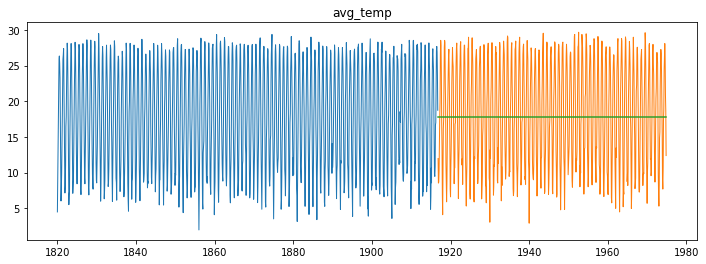

avg_uncertainty -- RMSE: 1


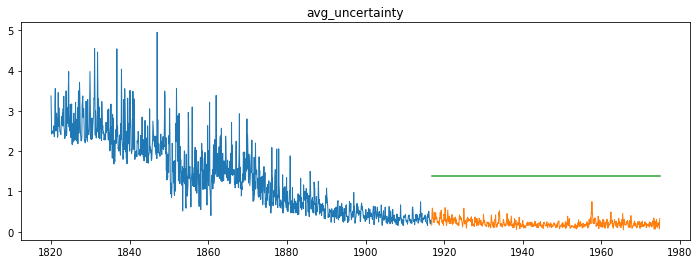

In [35]:
#plot actual vs predicted
for col in train.columns:
    plot_and_eval(col)

In [36]:
#evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,last_observed_value,avg_uncertainty,0.0
2,simple_average,avg_temp,7.0
3,simple_average,avg_uncertainty,1.0


### Moving Average
Use a specified moving average to forecast. In other words, the average over the last specified time will be used as the forecasted value.

In [37]:
period = 30 

# take 30 day rolling average, then take the last element and that will be the one that propogates forward as prediction. 
avg_temp = round(train['avg_temp'].rolling(period).mean()[-1], 2)
avg_uncertainty = round(train['avg_uncertainty'].rolling(period).mean()[-1], 2)

print(avg_temp, avg_uncertainty)

19.24 0.31


In [38]:
yhat_df = make_predictions()
yhat_df.head()

,avg_temp,avg_uncertainty
date,,
1916-11-01,19.24,0.31
1916-12-01,19.24,0.31
1917-01-01,19.24,0.31
1917-02-01,19.24,0.31
1917-03-01,19.24,0.31


avg_temp -- RMSE: 7


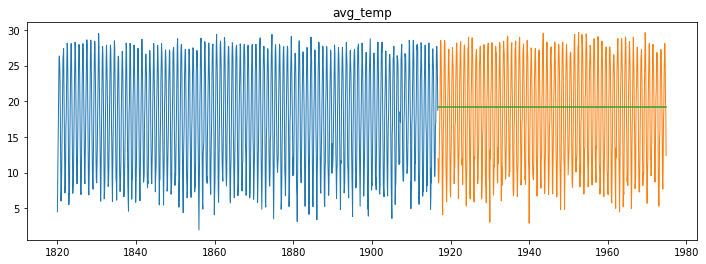

avg_uncertainty -- RMSE: 0


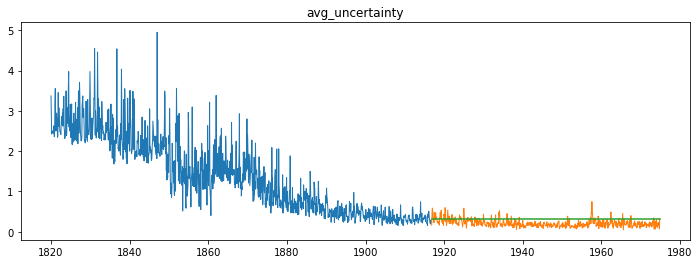

In [39]:
#plot actual vs predicted
for col in train.columns:
    plot_and_eval(col)

In [40]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,last_observed_value,avg_uncertainty,0.0
2,simple_average,avg_temp,7.0
3,simple_average,avg_uncertainty,1.0
4,30d_moving_avg,avg_temp,7.0
5,30d_moving_avg,avg_uncertainty,0.0


### Holt's Linear Trend
Exponential smoothing applied to both the average and the trend (slope).

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.

Holt:

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future. To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1.


fit:

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us.

avg_temp 



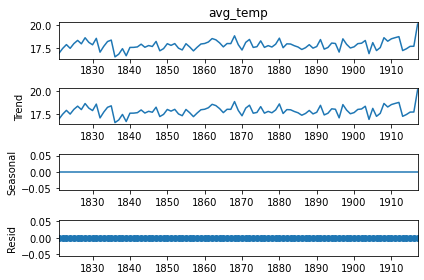

avg_uncertainty 



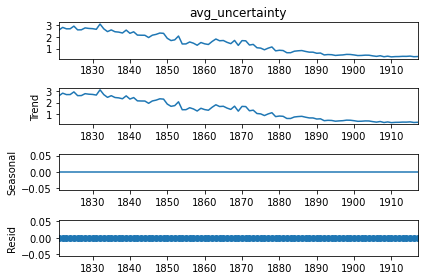

In [41]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()
    plt.show()

In [42]:
for col in train.columns:
    model = Holt(train[col], exponential=True, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)
    
yhat_df.head()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,avg_temp,avg_uncertainty
date,,
1916-11-01,16.08,0.3
1916-12-01,14.03,0.3
1917-01-01,12.58,0.3
1917-02-01,11.53,0.3
1917-03-01,10.75,0.3


avg_temp -- RMSE: 13


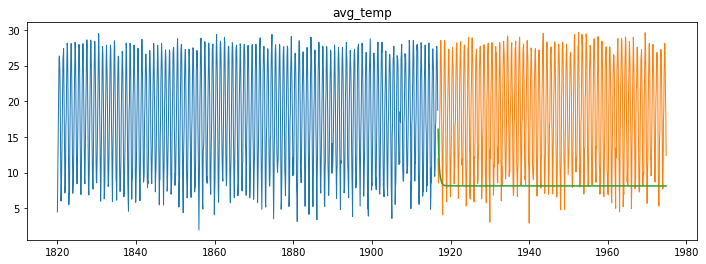

avg_uncertainty -- RMSE: 0


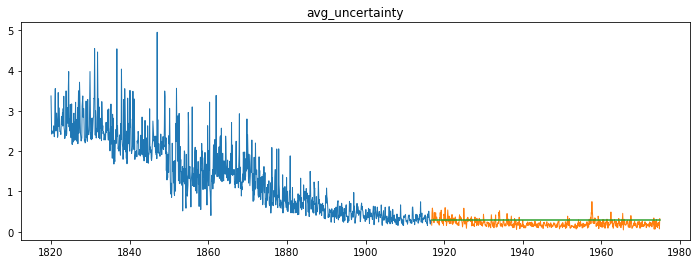

In [43]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [44]:
#append eval dataframe with holts optimized model evaluation metrics
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,last_observed_value,avg_uncertainty,0.0
2,simple_average,avg_temp,7.0
3,simple_average,avg_uncertainty,1.0
4,30d_moving_avg,avg_temp,7.0
5,30d_moving_avg,avg_uncertainty,0.0
6,holts_optimized,avg_temp,13.0
7,holts_optimized,avg_uncertainty,0.0


In [45]:
#changing hyperparameters
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=.1, 
                      smoothing_slope=.1, 
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


avg_temp -- RMSE: 102


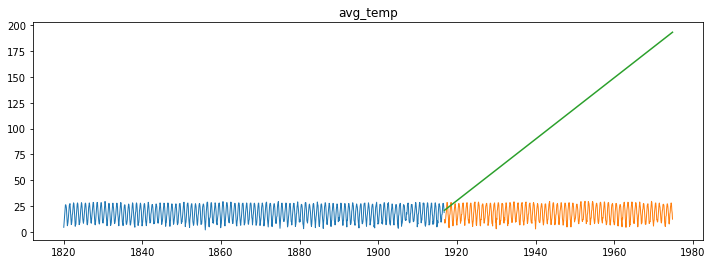

avg_uncertainty -- RMSE: 1


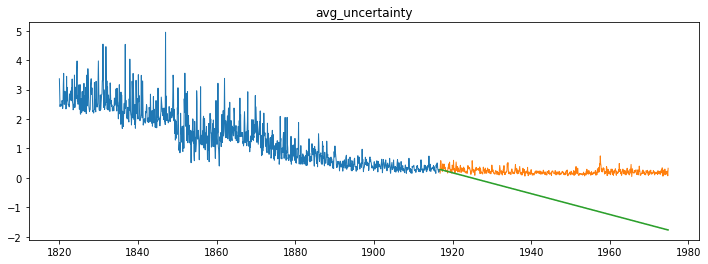

In [46]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [47]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
1,last_observed_value,avg_uncertainty,0.0
5,30d_moving_avg,avg_uncertainty,0.0
7,holts_optimized,avg_uncertainty,0.0
3,simple_average,avg_uncertainty,1.0
9,holts_.1,avg_uncertainty,1.0
0,last_observed_value,avg_temp,7.0
2,simple_average,avg_temp,7.0
4,30d_moving_avg,avg_temp,7.0
6,holts_optimized,avg_temp,13.0
8,holts_.1,avg_temp,102.0


### Previous Cycle
Take all the previous year's data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give the forecast for that day.

In [48]:
#re-split data
train = df[:'2010']
validate = df['2011']
test = df['2012']

train.shape, validate.shape, test.shape

((2292, 2), (12, 2), (12, 2))

In [49]:
# finding the year-over-year difference for each day from 1820 to 2010
# taking the mean, and then adding that value to the daily 2010 values. 

yhat_df = train['2010'] + train.diff(365).mean()
yhat_df.head()

,avg_temp,avg_uncertainty
date,,
2010-01-01,6.924656,-0.31578
2010-02-01,6.785656,-0.31178
2010-03-01,12.917656,-0.21478
2010-04-01,18.633656,-0.33178
2010-05-01,23.584656,-0.28178


In [50]:
#peeking into the prediction for 1/1/2011 by comparing predicted value (2010 value + y-o-y avg diff)to actual 1/1/2011 value
pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp,avg_uncertainty
date,,
2010-01-01,6.924656,-0.31578
2011-01-01,7.121000,0.19800


In [51]:
# set yhat_df to index of validate

yhat_df.index = validate.index
yhat_df

,avg_temp,avg_uncertainty
date,,
2011-01-01,6.924656,-0.31578
2011-02-01,6.785656,-0.31178
2011-03-01,12.917656,-0.21478
2011-04-01,18.633656,-0.33178
2011-05-01,23.584656,-0.28178
2011-06-01,28.538656,-0.27478
2011-07-01,27.885656,-0.21478
2011-08-01,29.569656,-0.15178
2011-09-01,25.788656,-0.29678


avg_temp -- RMSE: 2


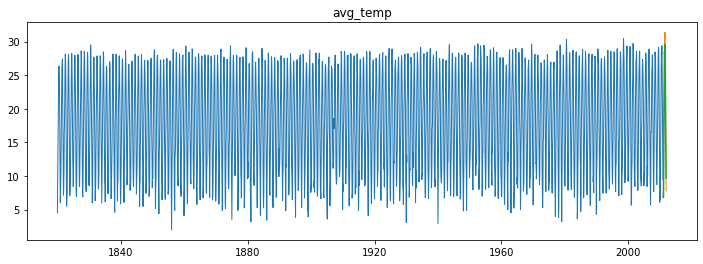

avg_uncertainty -- RMSE: 0


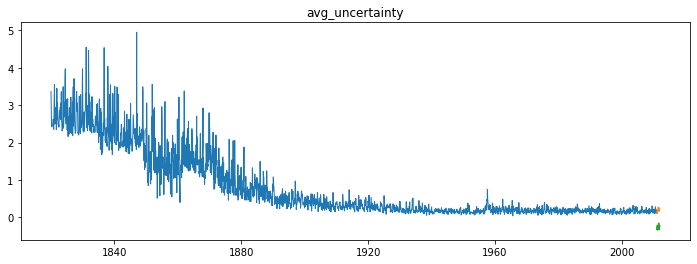

In [52]:
#plot and evaluate
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_cycle", 
                            target_var = col)

In [53]:
#find which model did that best
avg_temp_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

avg_uncertainty_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

eval_df[((eval_df.rmse == avg_temp_rmse) | 
         (eval_df.rmse == avg_uncertainty_min_rmse))]


avg_temp_min_rmse= eval_df.groupby('target_var')['rmse'].min()[0]

avg_uncertainty_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

eval_df[((eval_df.rmse == avg_temp_min_rmse) | 
         (eval_df.rmse == avg_uncertainty_min_rmse))]

,model_type,target_var,rmse
1,last_observed_value,avg_uncertainty,0.0
5,30d_moving_avg,avg_uncertainty,0.0
7,holts_optimized,avg_uncertainty,0.0
10,previous_cycle,avg_temp,2.0
11,previous_cycle,avg_uncertainty,0.0


***
# Conclusion
#### Previous cycle model performs the best for avg_temp and avg_uncertainty, so it will be used moving forward for out of sample data.

In [54]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [55]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.xlim(left = 1990)
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [56]:
rmse_avg_temp = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_uncertainty']))

rmse_avg_uncertainty = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_uncertainty']))

print('rmse_avg_temp: ', rmse_avg_temp)
print('rmse_avg_uncertainty: ', rmse_avg_uncertainty)

rmse_avg_temp:  21.317769440982183
rmse_avg_uncertainty:  21.317769440982183


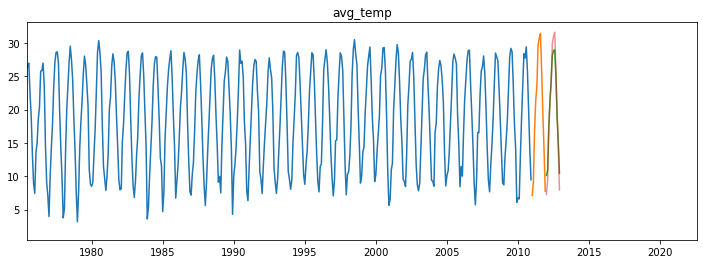

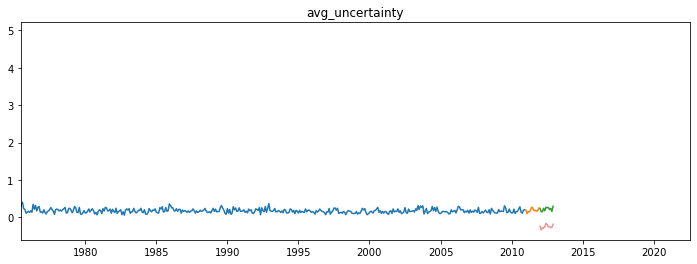

In [57]:
for col in train.columns:
    final_plot(col)